In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_sheet
from peripodial.anisotropy import angle_distribution

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


Text(0, 0.5, 'D-V axis')

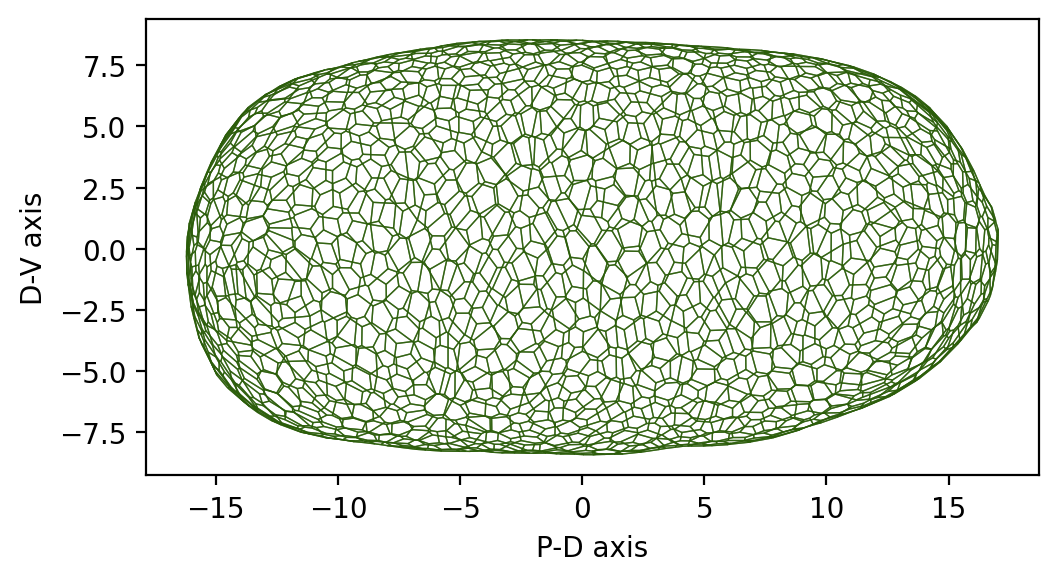

In [4]:
fig, ax = sheet_view(sheet, coords=["z", "x"])
ax.set_xlabel('P-D axis')
ax.set_ylabel('D-V axis')


In [5]:
sheet.face_df["area"].mean()

1.005847100697268

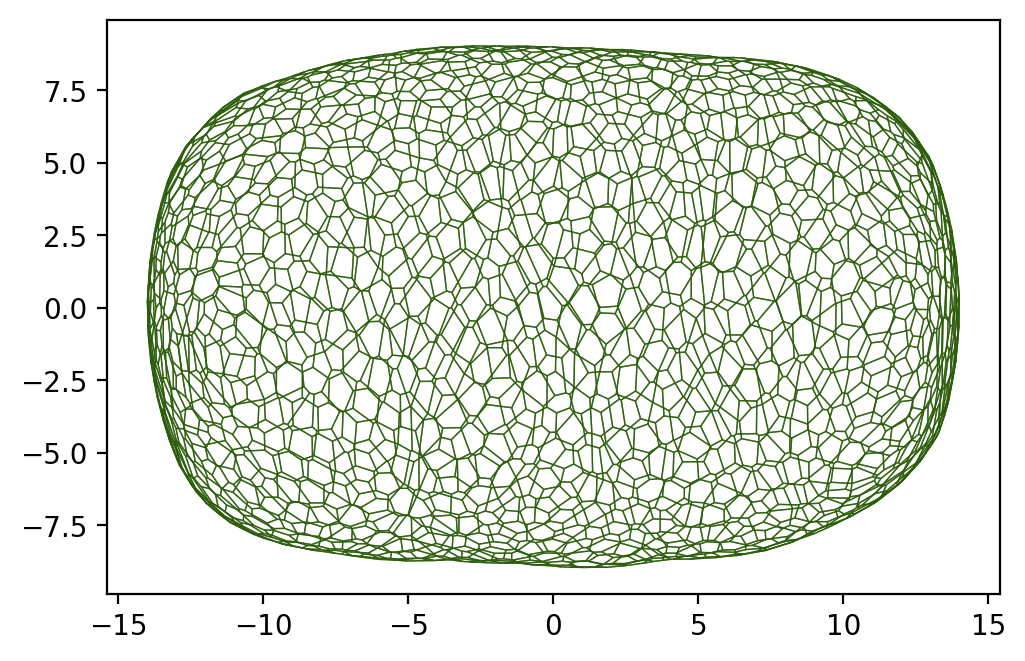

In [6]:
specs['settings']["barrier_radius"] = 14
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [7]:
#### verify that the function update_weight works
"""change = []
sheet_copy = sheet.copy()
theta = np.pi / 3

for i in range(10): 
    
    print(f"{i+1} / 10", end=" ")
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1.0,
    )
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)


sheet_copy1 = sheet_copy.copy()
sheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] 

draw_specs = {'vert': {
            'visible': False
            },
        'edge': {
            'color': sheet_copy1.edge_df["weight"],
            'colormap': "coolwarm",
            'width': sheet_copy1.edge_df["weight"]
            #'zorder': depth.values
            }
        }

fig, ax = sheet_view(sheet_copy1, ["z", "x"], mode='2D', **draw_specs)
ax.set_facecolor('#101010')
print(change)"""


'change = []\nsheet_copy = sheet.copy()\ntheta = np.pi / 3\n\nfor i in range(10): \n    \n    print(f"{i+1} / 10", end=" ")\n    z_orientation = update_weights(\n        sheet_copy, \n        threshold_angle=theta, \n        below_threshold=0.5,\n        above_threshold=1.0,\n    )\n    solver = QSSolver(with_t1=False, with_t3=False)\n    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})\n    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)\n\n\nsheet_copy1 = sheet_copy.copy()\nsheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] \n\ndraw_specs = {\'vert\': {\n            \'visible\': False\n            },\n        \'edge\': {\n            \'color\': sheet_copy1.edge_df["weight"],\n            \'colormap\': "coolwarm",\n            \'width\': sheet_copy1.edge_df["weight"]\n            #\'zorder\': depth.values\n            }\n        }\n\nfig, ax = sheet_view(sheet_copy1, ["z", "x"], mode=\'2D\', **draw_specs)\nax.set_fac

In [8]:
aniso(sheet, coords = ['x','y','z'])

face
0       0.172544
1       0.298766
2       0.258228
3       0.205229
4       0.314538
          ...   
1647    0.444752
1648    0.154137
1649    0.305435
1650    0.195247
1651    0.082935
Name: anisotropy, Length: 1652, dtype: float64

/home/lglepin/miniconda3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


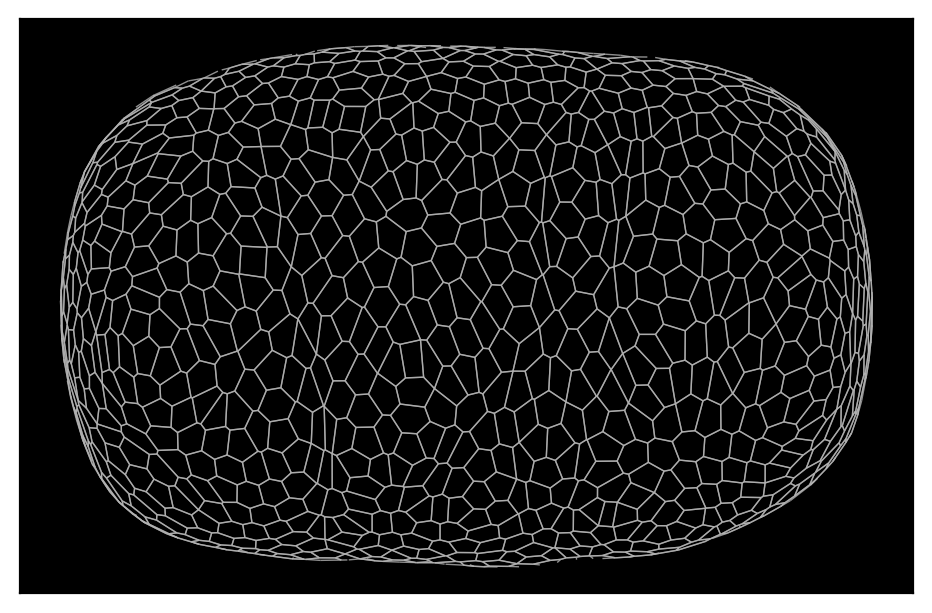

In [9]:
fig, ax = draw_half_sheet(sheet, ax=None)
ax.set_facecolor("black")

In [10]:
sheets_obj = {}
aniso_cell_values_d = []
angle_vs = []
theta = np.pi / 3
bts = np.arange(0.4, 0.1, -0.05)
angle_vs = []

for i, below_threshold in enumerate(bts):
    
    print(f"{i+1} / {7}", end=" ")
    z_orientation = update_weights(
        sheet, 
        threshold_angle=theta, 
        below_threshold=below_threshold,
        above_threshold=0.5,
    )
    geom.update_all(sheet)
    solver = QSSolver(with_t1=True, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    angle_v = np.arcsin(z_orientation)
    angle_degrees = np.degrees(angle_v)
    sheet.face_df['anisotropy'] = aniso(sheet, coords = ['x','y','z'])
    center = np.abs(sheet.face_df["z"]) < sheet.face_df["z"].max()*0.75
    aniso_cell = sheet.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    angle_vs.append(angle_degrees)
    sheet_copy = sheet.copy()
    sheets_obj[below_threshold] = sheet_copy




print(angle_degrees)


1 / 7 2 / 7 3 / 7 4 / 7 5 / 7 6 / 7 7 / 7 edge
0       87.690683
1       18.941688
2       59.738481
3       38.286212
4       44.071545
          ...    
9895    47.620833
9896    54.665969
9897    54.665969
9898    58.808705
9899    58.808705
Length: 9900, dtype: float64


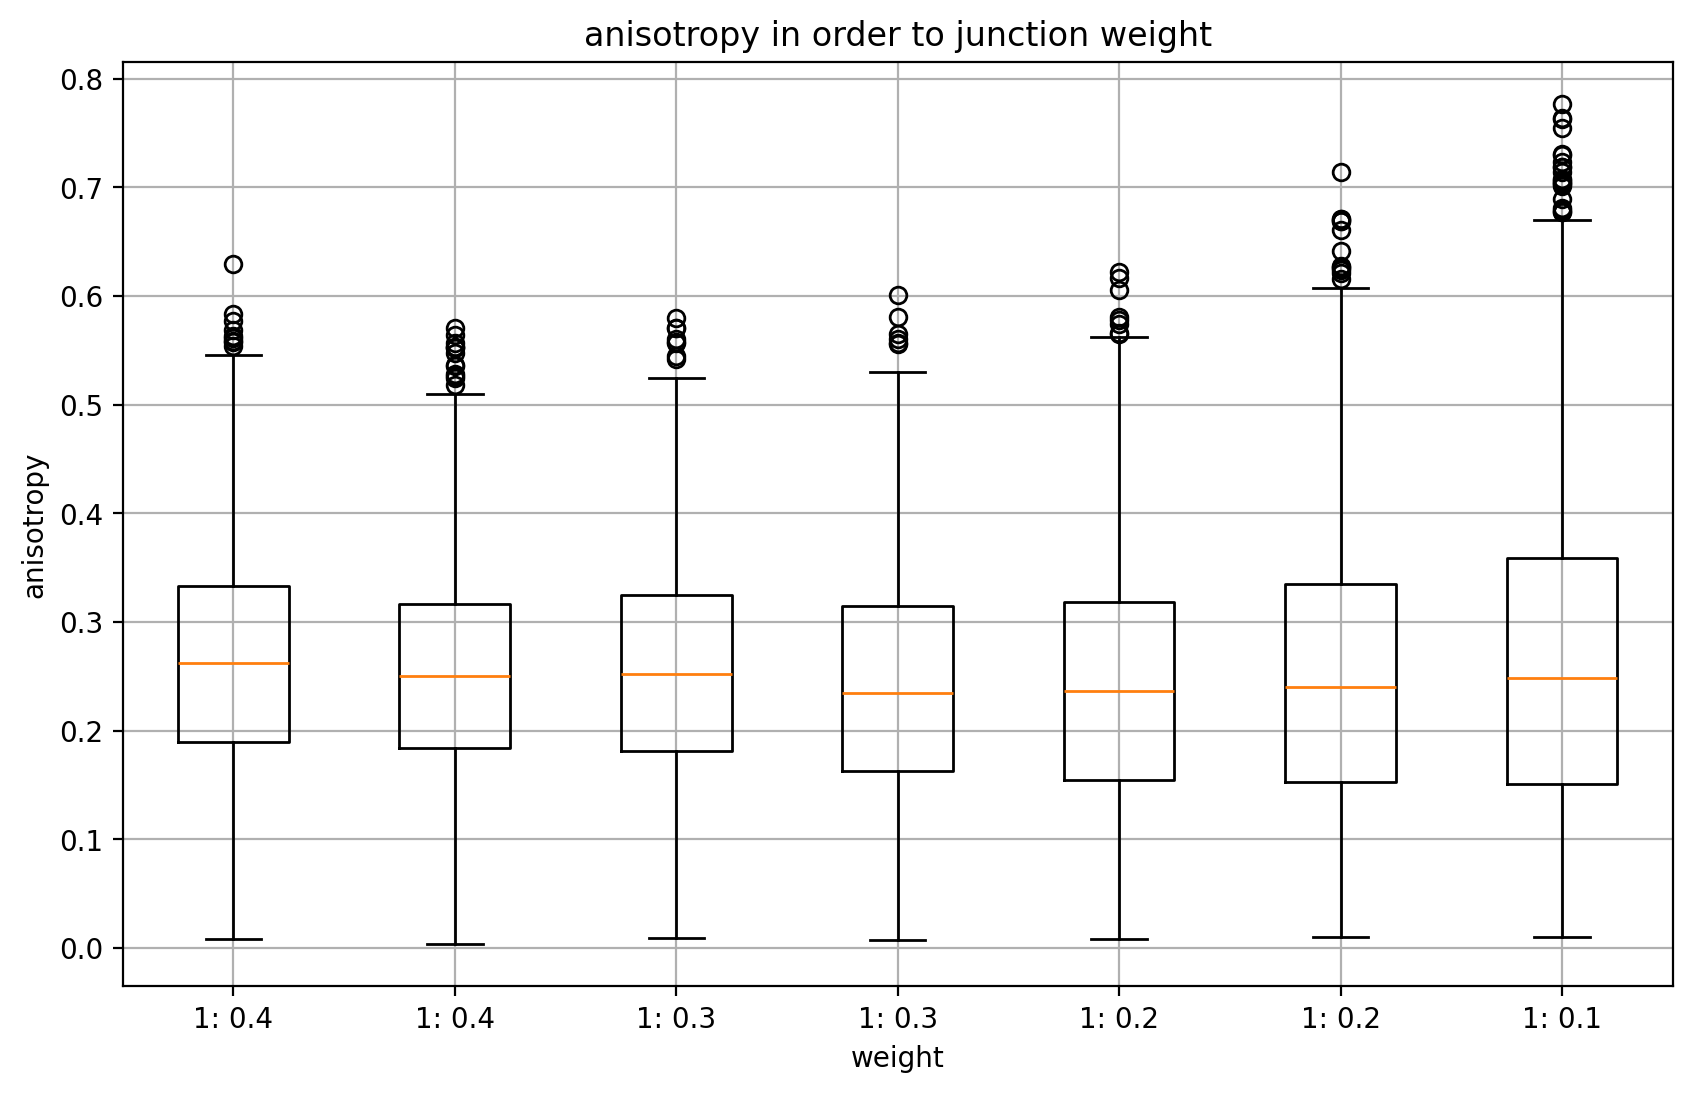

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(aniso_cell_values_d)
plt.title('anisotropy in order to junction weight')
plt.xlabel('weight')
plt.ylabel('anisotropy')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['1: {:.1f}'.format(i) for i in bts])
plt.grid(True)
plt.savefig('../image/plot_aniso_weight.png', transparent=False)
plt.show()


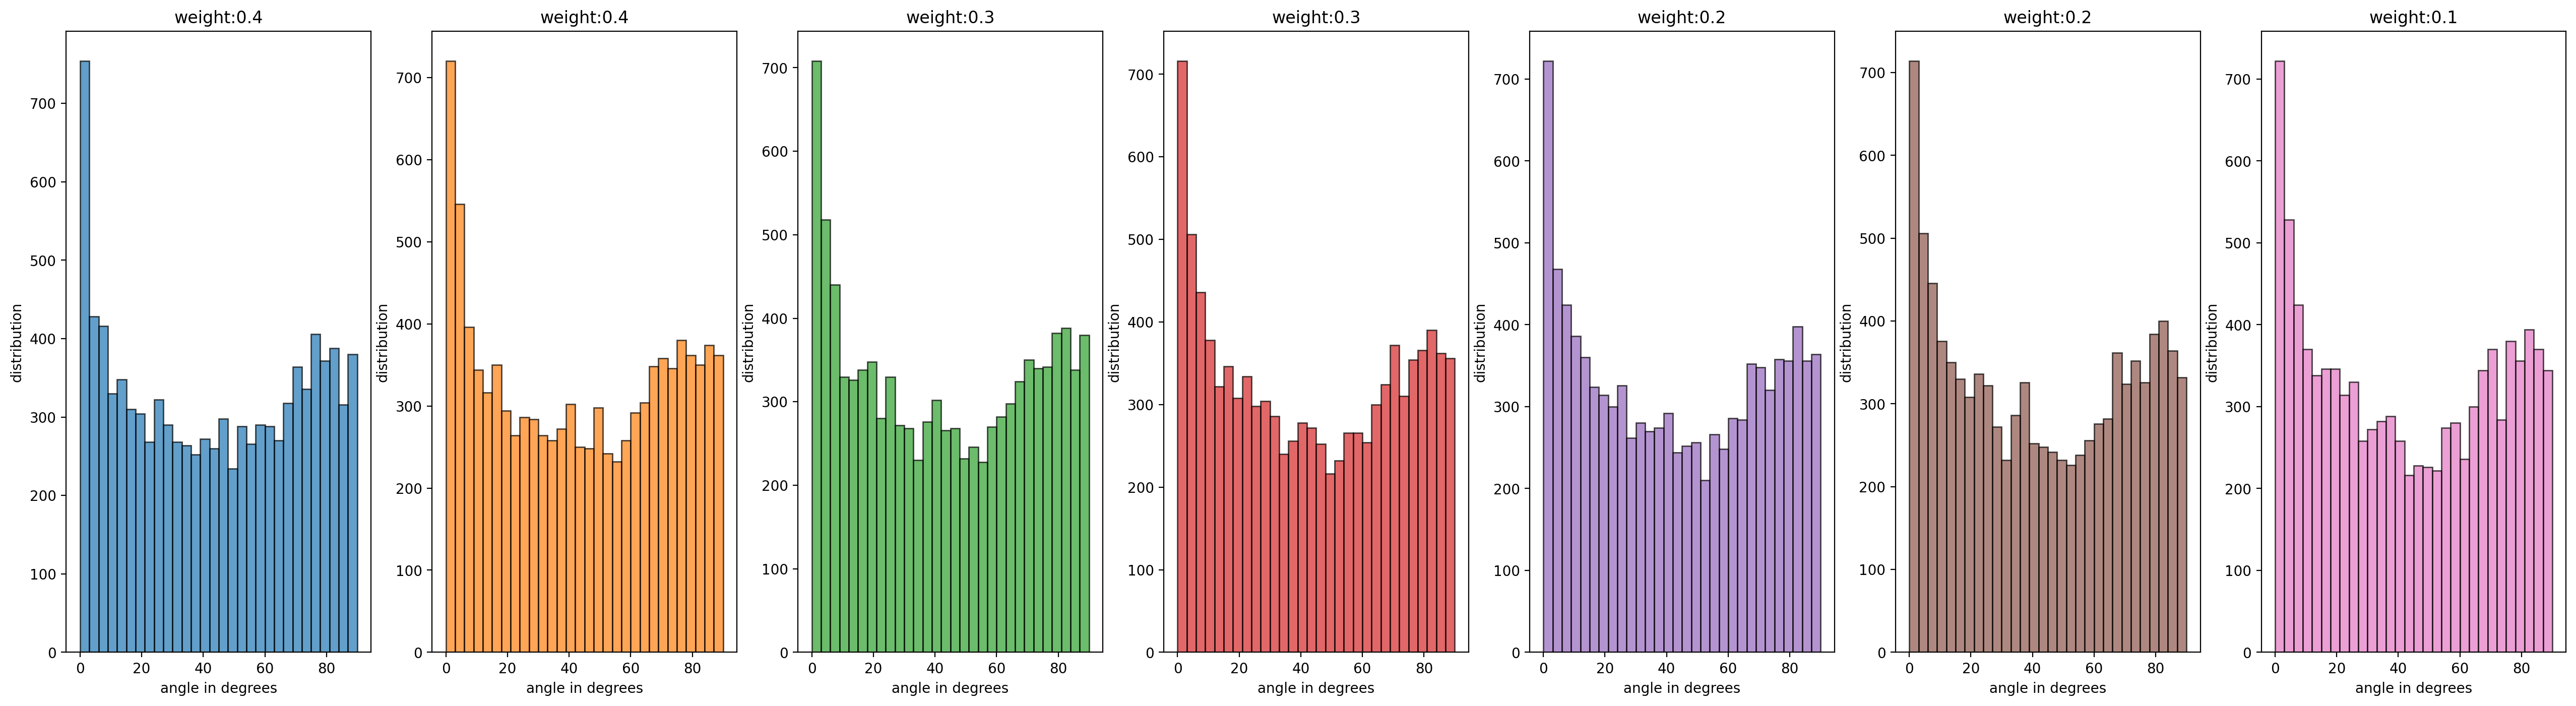

In [12]:
fig, axs = plt.subplots(1, len(angle_vs), figsize=(32, 8))

for i, data in enumerate(angle_vs):
    axs[i].hist(data, bins=30, color='C{}'.format(i), alpha=0.7, edgecolor='black')
    axs[i].set_title('weight:{:.1f}'.format(bts[i]))
    axs[i].set_ylabel('distribution')
    axs[i].set_xlabel('angle in degrees')
plt.savefig('../image/plot_distribution_angle.png', transparent=False)
plt.show()

In [13]:
sheet.edge_df

,srce,trgt,face,dx,dy,dz,nx,ny,nz,sx,...,uz,line_tension,weight,unique_id,weight_length,rx,ry,rz,weighted_length,num_sides
edge,,,,,,,,,,,,,,,,,,,,,
0,707,523,1632,0.125473,0.243565,0.004621,-0.074996,0.035368,0.172184,-3.763037,...,0.016863,0.01,1.000000,1,0.187637,0.490016,-0.421073,0.299920,0.274023,7
1,3222,2569,178,0.253081,-0.007922,0.380735,-0.027632,-0.309610,0.011926,-0.504830,...,0.832674,0.01,0.428571,2,0.419500,0.371117,-0.058738,-0.665057,0.195962,6
2,1066,707,1632,0.801068,0.133466,0.312780,-0.171732,0.086989,0.402709,-4.564106,...,0.359409,0.01,1.000000,3,0.572184,-0.311053,-0.554539,-0.012860,0.870261,7
3,940,2145,834,-0.006490,-0.555041,0.426156,-0.344141,0.177559,0.226018,-6.179592,...,0.608968,0.01,0.466667,5,0.378270,-0.408308,-0.093940,-0.547903,0.326574,7
4,909,564,1091,-0.317739,0.096622,-0.206873,-0.070352,-0.196556,0.016251,-3.023757,...,-0.528725,0.01,0.466667,6,0.512587,-0.061928,0.069977,0.578289,0.182591,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,3297,629,739,-0.016765,-0.029716,0.030394,0.011975,0.014988,0.021259,3.631052,...,0.665169,0.01,1.470588,1066,0.346200,-0.475628,0.425019,-0.031741,0.067196,5
9896,659,3298,1622,0.016543,0.034375,0.006643,0.017537,-0.009609,0.006051,7.184088,...,0.171555,0.01,1.666667,637,0.433267,0.180970,0.010250,-0.508190,0.064537,4
9897,3298,659,812,-0.016543,-0.034375,-0.006643,0.013381,-0.006975,0.002767,7.200631,...,-0.171555,0.01,2.142857,2311,0.521764,-0.116758,-0.075365,0.374715,0.082977,6


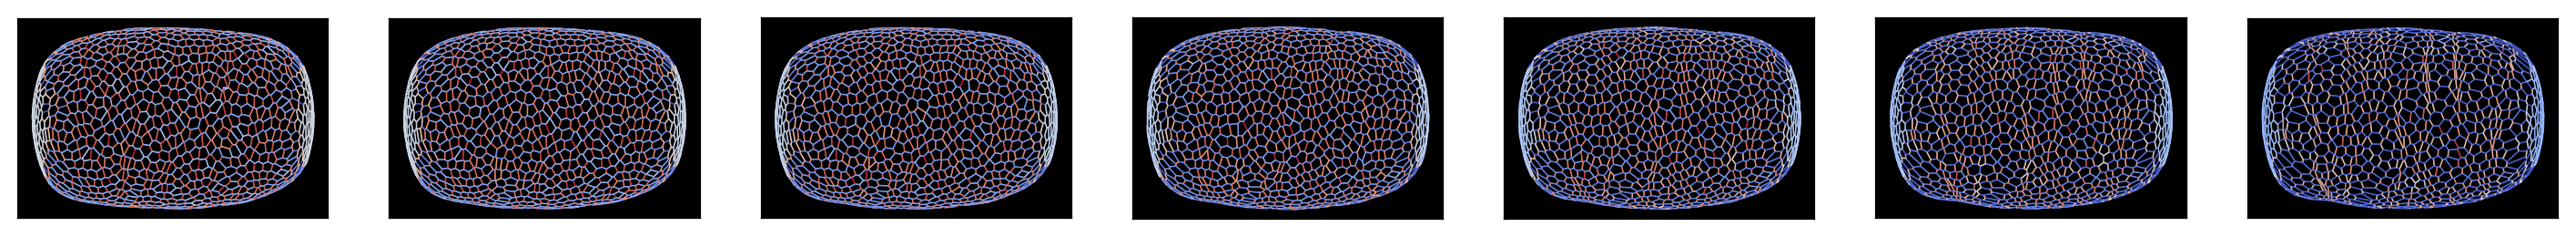

In [14]:
fig, axes = plt.subplots(1, len(sheets_obj), figsize=(28, 8))

for i, (above_threshold, sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_sheet(sheet_copy, axes[i])
    #ax.set_xlabel(f"1:{below_threshlod:.1f}")
    ax.set_facecolor("black")
fig.set_size_inches(18, 5)
plt.savefig('../image/aniso_weight.png', transparent=False)


In [ ]:
from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/polarity.hdf5",sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/polarity.json", overwrite=True)